In [1]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.datasets._base import _pkl_filepath, get_data_home
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures

In [2]:
! pip install ucimlrepo

# Data
from ucimlrepo import fetch_ucirepo

forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets

# Display dataset structure
print(X.info())
print(X.describe())
print(y.head())
print(y.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB
None
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192 

In [3]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [4]:
X_encoded.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_may,month_nov,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,False,False,False,False,False,False,False,False,False,False
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,False,False,True,False,False,False,False,False,True,False
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,False,False,True,False,False,True,False,False,False,False
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,False,False,False,False,False,False,False,False,False,False
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,False,False,False,False,False,False,True,False,False,False


In [5]:
X.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


In [6]:
y.head()

,area
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [7]:
X['month'].value_counts()

month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64

In [8]:
X_encoded['target'] = y

corr_matrix = X_encoded.corr()

target_corr = corr_matrix['target'].sort_values(ascending=False)

In [9]:
target_corr

target       1.000000
temp         0.097844
day_sat      0.087868
DMC          0.072994
X            0.063385
month_sep    0.056573
DC           0.049383
Y            0.044873
FFMC         0.040122
day_thu      0.020121
wind         0.012317
ISI          0.008258
month_may    0.006264
month_jul    0.006149
month_dec    0.001010
day_tue     -0.001333
month_aug   -0.004187
rain        -0.007366
month_nov   -0.008893
day_wed     -0.011452
month_jan   -0.012589
month_oct   -0.016878
month_jun   -0.020314
day_sun     -0.020463
month_feb   -0.020732
day_mon     -0.021206
month_mar   -0.045596
RH          -0.075519
Name: target, dtype: float64

I think we can drop days, which shouldn't be great indicators in theory. If we had a particular standout, we maybe could look into man-made causes
that would lead to higher correlation  with days. 

For months, after some research I think a cyclical numeric method would be most beneficial. Let's transform the months column

In [10]:
X.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


In [11]:
X = X.drop(columns=['day'])

In [12]:
months_map = {
    'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
    'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12
}
months_num = X['month'].map(months_map)

X['month_sin'] = np.sin(2 * np.pi * months_num / 12)
X['month_cos'] = np.cos(2 * np.pi * months_num / 12)

In [13]:
X.head()

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_sin,month_cos
0,7,5,mar,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1.000000,6.123234e-17
1,7,4,oct,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,-0.866025,5.000000e-01
2,7,4,oct,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,-0.866025,5.000000e-01
3,8,6,mar,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1.000000,6.123234e-17
4,8,6,mar,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,1.000000,6.123234e-17


In [14]:
#This function will allow us to convert these sin/cos back into meaningful dates later

def month_from_sin_cos(month_sin, month_cos):
    angle = np.arctan2(month_sin, month_cos)
    if angle < 0:
        angle += 2 * np.pi  # Convert negative angles to positive
    month_num = (angle * 12) / (2 * np.pi)
    return month_num

# Example usage
sin_val = 0.8
cos_val = 0.02

approx_month = month_from_sin_cos(sin_val, cos_val)
print(f"Approximated month number: {approx_month:.2f}")
#This would be late Feb

Approximated month number: 2.95


In [15]:
data = X.drop(columns = ['month'])
data['target'] = y

corr_matrix = data.corr()

target_corr = corr_matrix['target'].sort_values(ascending=False)
target_corr

target       1.000000
temp         0.097844
DMC          0.072994
X            0.063385
DC           0.049383
Y            0.044873
FFMC         0.040122
wind         0.012317
ISI          0.008258
month_cos   -0.001847
rain        -0.007366
month_sin   -0.059179
RH          -0.075519
Name: target, dtype: float64

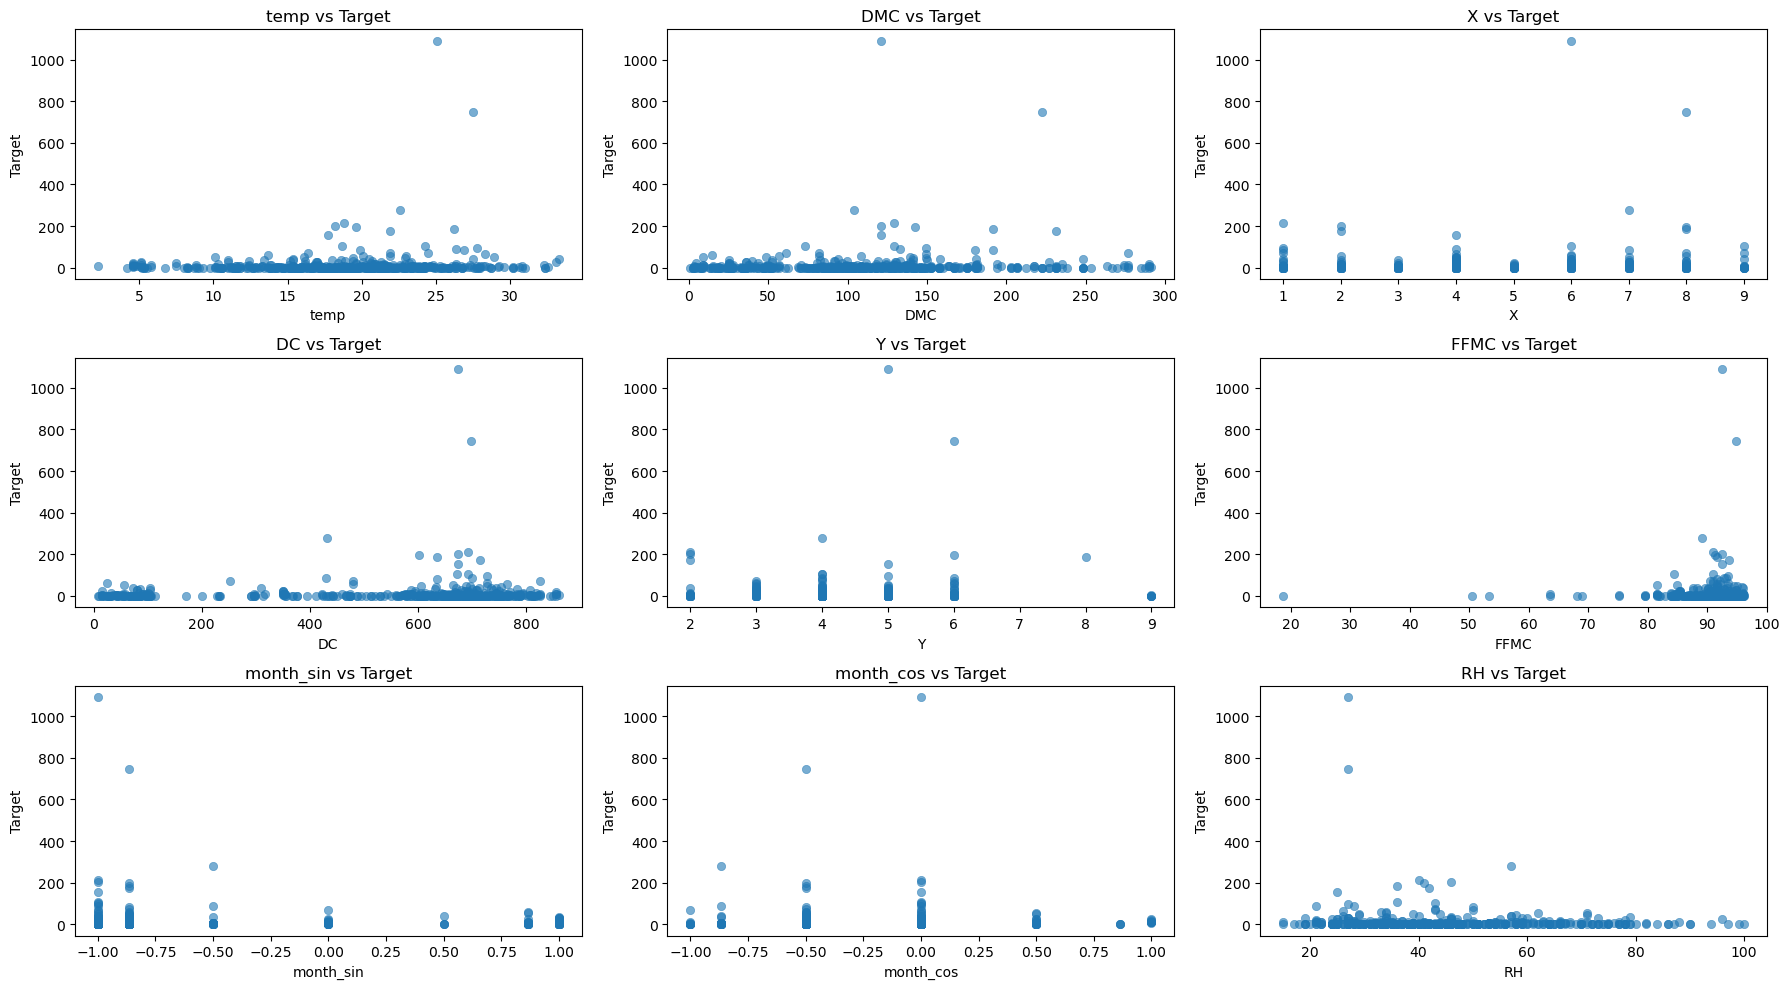

In [16]:
key_features = ['temp', 'DMC', 'X', 'DC', 'Y', 'FFMC', 'month_sin', 'month_cos', 'RH']

plt.figure(figsize=(18, 10))
for i, feature in enumerate(key_features):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=data, x=feature, y='target', alpha=0.6, edgecolor=None)
    plt.title(f'{feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')

plt.tight_layout()
plt.show()

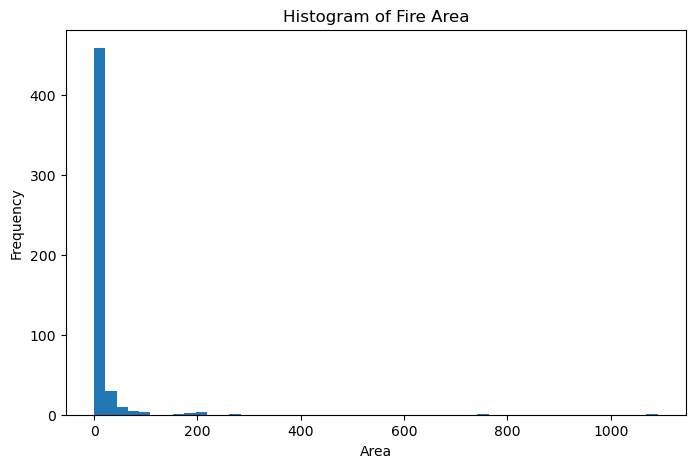

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(y, bins=50)
plt.title('Histogram of Fire Area')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()

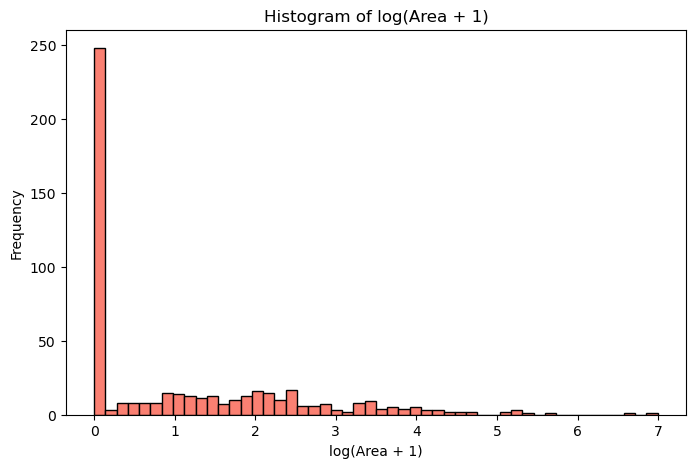

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(np.log1p(y), bins=50, color='salmon', edgecolor='black')
plt.title('Histogram of log(Area + 1)')
plt.xlabel('log(Area + 1)')
plt.ylabel('Frequency')
plt.show()

With a heavy skew in target area, a log transform appears to be needed

I am confused by this instruction - "Generate a residual plot to check for randomness in residuals."
We haven't fit a model yet.

In [19]:
print(X.shape, y.shape)

(517, 13) (517, 1)


In [20]:
X_model = X[key_features]
y_model = np.log1p(y)
X_model = sm.add_constant(X_model)

model = sm.OLS(y_model, X_model).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.781
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0692
Time:                        21:02:29   Log-Likelihood:                -898.42
No. Observations:                 517   AIC:                             1817.
Df Residuals:                     507   BIC:                             1859.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6504      1.369      0.475      0.6

Extremely low R^2, adjusted is lower. No predictors appear to be statistically significant. As noted by the results, the high condition number suggests multicollinearity. 

In [21]:
y_pred = model.predict(X_model)
residuals = model.resid

y_pred.shape, residuals.shape

((517,), (517,))

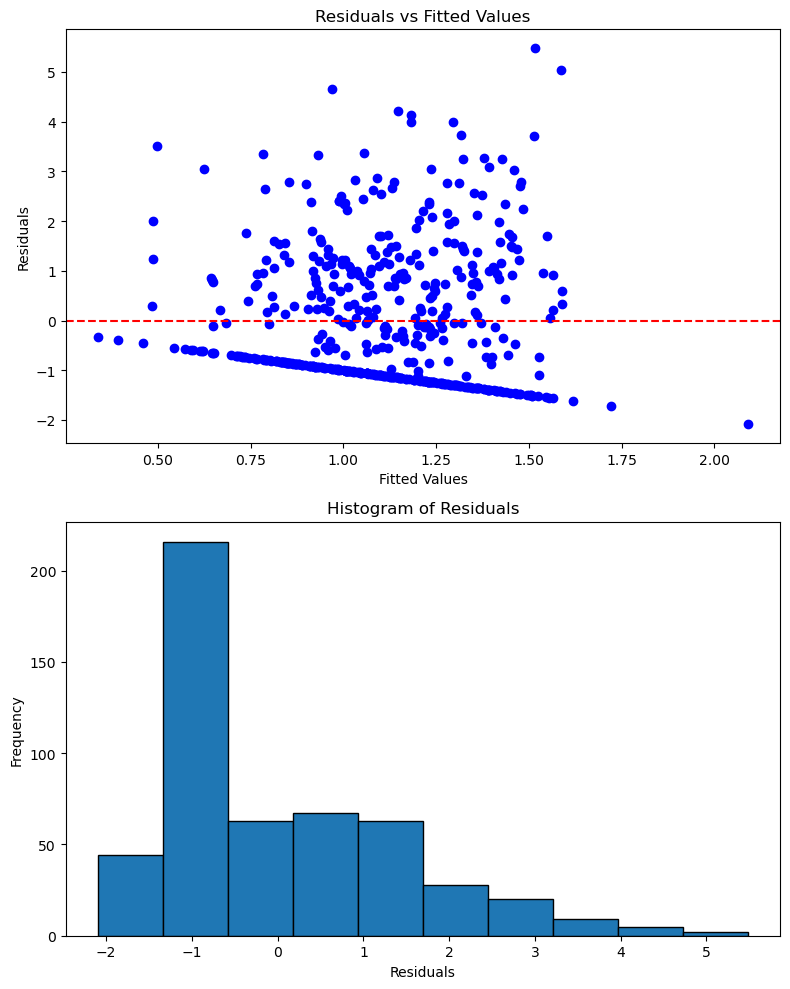

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 2 rows, 1 column

axes[0].scatter(model.fittedvalues, residuals, color='blue')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')

axes[1].hist(residuals, bins=10, edgecolor='black')
axes[1].set_title('Histogram of Residuals')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

Plot is skewed, shows pattern. Not random suggesting violations of linearity

               temp       DMC         X        DC         Y      FFMC  \
temp       1.000000  0.469594 -0.051258  0.496208 -0.024103  0.431532   
DMC        0.469594  1.000000 -0.048384  0.682192  0.007782  0.382619   
X         -0.051258 -0.048384  1.000000 -0.085916  0.539548 -0.021039   
DC         0.496208  0.682192 -0.085916  1.000000 -0.101178  0.330512   
Y         -0.024103  0.007782  0.539548 -0.101178  1.000000 -0.046308   
FFMC       0.431532  0.382619 -0.021039  0.330512 -0.046308  1.000000   
month_sin -0.537079 -0.620175  0.085986 -0.953070  0.091156 -0.327529   
month_cos -0.487953 -0.418676 -0.041758 -0.104640 -0.030249 -0.289230   
RH        -0.527390  0.073795  0.085223 -0.039192  0.062221 -0.300995   

           month_sin  month_cos        RH  
temp       -0.537079  -0.487953 -0.527390  
DMC        -0.620175  -0.418676  0.073795  
X           0.085986  -0.041758  0.085223  
DC         -0.953070  -0.104640 -0.039192  
Y           0.091156  -0.030249  0.062221  
FFMC 

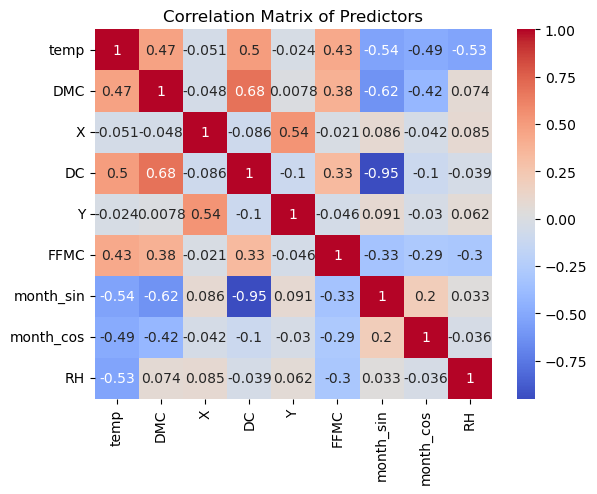

In [23]:
correlation_matrix = data[key_features].corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Predictors')
plt.show()

In [24]:
variance_inflation_factor

X_1 = data[key_features]
X_1 = sm.add_constant(X_1)

vif_data = pd.DataFrame()
vif_data['Variable'] = X_1.columns
vif_data['VIF'] = [variance_inflation_factor(X_1.values, i) for i in range(X_1.shape[1])]

print(vif_data)

    Variable         VIF
0      const  502.432278
1       temp    3.646218
2        DMC    3.032026
3          X    1.441434
4         DC   17.895564
5          Y    1.453927
6       FFMC    1.404254
7  month_sin   14.685434
8  month_cos    2.292765
9         RH    2.247587


There is a high correalation between DC and month_sin. Lets drop the month_sin component

In [25]:
key_features = ['temp', 'DMC', 'X', 'DC', 'Y', 'FFMC', 'month_cos', 'RH']

In [26]:
X_model = X[key_features]
y_model = np.log1p(y)
X_model = sm.add_constant(X_model)

model2 = sm.OLS(y_model, X_model).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.720
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0911
Time:                        21:02:29   Log-Likelihood:                -899.56
No. Observations:                 517   AIC:                             1817.
Df Residuals:                     508   BIC:                             1855.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0276      1.306      0.021      0.9

               temp       DMC         X        DC         Y      FFMC  \
temp       1.000000  0.469594 -0.051258  0.496208 -0.024103  0.431532   
DMC        0.469594  1.000000 -0.048384  0.682192  0.007782  0.382619   
X         -0.051258 -0.048384  1.000000 -0.085916  0.539548 -0.021039   
DC         0.496208  0.682192 -0.085916  1.000000 -0.101178  0.330512   
Y         -0.024103  0.007782  0.539548 -0.101178  1.000000 -0.046308   
FFMC       0.431532  0.382619 -0.021039  0.330512 -0.046308  1.000000   
month_cos -0.487953 -0.418676 -0.041758 -0.104640 -0.030249 -0.289230   
RH        -0.527390  0.073795  0.085223 -0.039192  0.062221 -0.300995   

           month_cos        RH  
temp       -0.487953 -0.527390  
DMC        -0.418676  0.073795  
X          -0.041758  0.085223  
DC         -0.104640 -0.039192  
Y          -0.030249  0.062221  
FFMC       -0.289230 -0.300995  
month_cos   1.000000 -0.035710  
RH         -0.035710  1.000000  


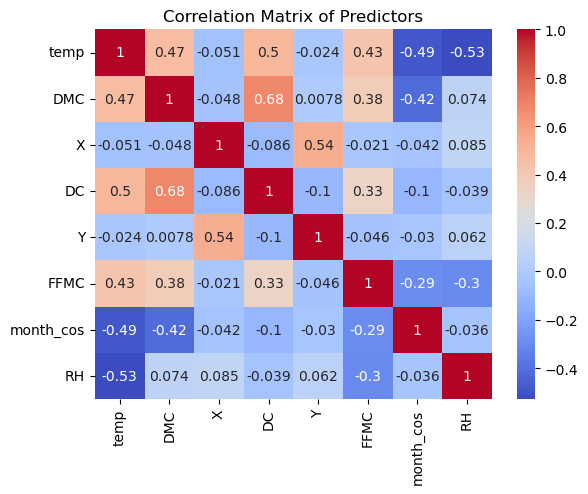

In [27]:
correlation_matrix = data[key_features].corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Predictors')
plt.show()

In [28]:
X_2 = data[key_features]
X_2 = sm.add_constant(X_2)

vif_data = pd.DataFrame()
vif_data['Variable'] = X_2.columns
vif_data['VIF'] = [variance_inflation_factor(X_2.values, i) for i in range(X_2.shape[1])]

print(vif_data)

    Variable         VIF
0      const  455.938298
1       temp    3.548431
2        DMC    2.597655
3          X    1.432838
4         DC    2.681929
5          Y    1.447533
6       FFMC    1.403944
7  month_cos    2.066976
8         RH    2.193396


Acceptable VIF

In [29]:
y_boxcox, lambda_opt = stats.boxcox(y.squeeze() + 1e-6)  # add small value since y contains zeros
print(f"Optimal lambda: {lambda_opt}")

Optimal lambda: 0.005008176279139941


This validates our log transform, lets look at predictors now

In [30]:
key_features

['temp', 'DMC', 'X', 'DC', 'Y', 'FFMC', 'month_cos', 'RH']

In [31]:
#month_cos is not positive, remove for boxcox

box_features = ['temp', 'DMC', 'X', 'DC', 'Y', 'FFMC', 'RH']

for feature in box_features:
    col_data = X[feature]
    boxcox, lambda_opt = stats.boxcox(col_data + 1e-6)  # add small value since preds contains zeros
    print(f"Optimal lambda: {lambda_opt}")

Optimal lambda: 1.2679828292138258
Optimal lambda: 0.6361921077722704
Optimal lambda: 0.7095627307577742
Optimal lambda: 1.4416133362872263
Optimal lambda: 0.6826517410670436
Optimal lambda: 12.701303777270267
Optimal lambda: -0.03060333645439146


For simplicity, rounding to nearest int:


'temp' -> temp

'DMC' -> DMC

'X' -> X

'DC'-> DC

'Y'-> Y

'FFMC'-> FFMC^13

'RH'-> log(RH)

In [32]:
X['FFMC13'] = X['FFMC'] ** 13
X['logRH'] = np.log(X['RH'])

In [33]:
feature = X['month_cos']

# Apply Yeo-Johnson transform
transformed_data, lambda_opt = stats.yeojohnson(feature)

print(f"Optimal lambda: {lambda_opt}")

Optimal lambda: 0.6042084206878886


In [34]:
new_features = ['temp', 'DMC', 'X', 'DC', 'Y', 'FFMC13', 'logRH', 'month_cos']

In [35]:
X_model = X[new_features]
y_model = np.log1p(y)
X_model = sm.add_constant(X_model)

model3 = sm.OLS(y_model, X_model).fit()

print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                      -0.063
Model:                            OLS   Adj. R-squared:                 -0.063
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 24 May 2025   Prob (F-statistic):                nan
Time:                        21:02:30   Log-Likelihood:                -922.26
No. Observations:                 517   AIC:                             1847.
Df Residuals:                     516   BIC:                             1851.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.767e-52   5.87e-53     16.626      0.0

               temp       DMC         X        DC         Y    FFMC13  \
temp       1.000000  0.469594 -0.051258  0.496208 -0.024103  0.618526   
DMC        0.469594  1.000000 -0.048384  0.682192  0.007782  0.491806   
X         -0.051258 -0.048384  1.000000 -0.085916  0.539548 -0.063853   
DC         0.496208  0.682192 -0.085916  1.000000 -0.101178  0.427274   
Y         -0.024103  0.007782  0.539548 -0.101178  1.000000 -0.027168   
FFMC13     0.618526  0.491806 -0.063853  0.427274 -0.027168  1.000000   
logRH     -0.501790  0.084086  0.080302 -0.014305  0.055065 -0.284671   
month_cos -0.487953 -0.418676 -0.041758 -0.104640 -0.030249 -0.390079   

              logRH  month_cos  
temp      -0.501790  -0.487953  
DMC        0.084086  -0.418676  
X          0.080302  -0.041758  
DC        -0.014305  -0.104640  
Y          0.055065  -0.030249  
FFMC13    -0.284671  -0.390079  
logRH      1.000000  -0.055391  
month_cos -0.055391   1.000000  


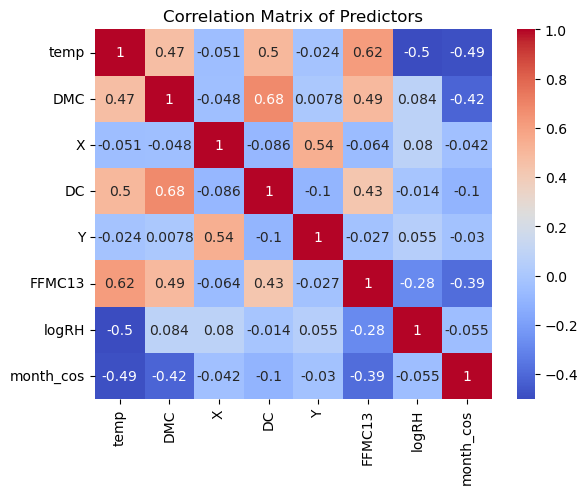

In [36]:
correlation_matrix = X[new_features].corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Predictors')
plt.show()

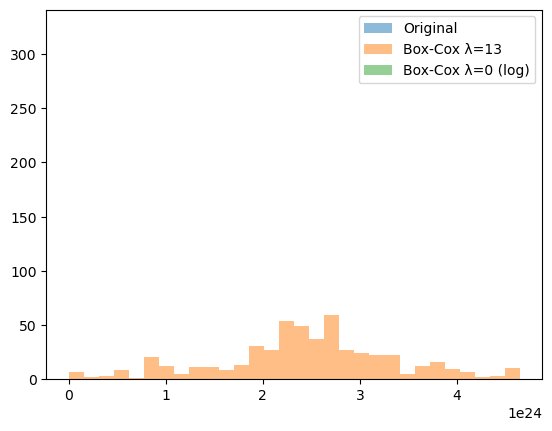

In [37]:
ad = X['FFMC'] + 1e-6  # make sure positive

# Apply Box-Cox with lambda = 13
transformed_13 = (ad ** 13 - 1) / 13

# Apply Box-Cox with lambda = 1 (no transform) and 0 (log)
transformed_1 = ad
transformed_0 = np.log(ad)

plt.hist(ad, bins=30, alpha=0.5, label='Original')
plt.hist(transformed_13, bins=30, alpha=0.5, label='Box-Cox λ=13')
plt.hist(transformed_0, bins=30, alpha=0.5, label='Box-Cox λ=0 (log)')
plt.legend()
plt.show()

In [38]:
#lambda of 13 is way too high. Need to find a proper transformation
X.drop(columns='FFMC13', inplace=True)

In [39]:
X.head()

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_sin,month_cos,logRH
0,7,5,mar,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1.000000,6.123234e-17,3.931826
1,7,4,oct,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,-0.866025,5.000000e-01,3.496508
2,7,4,oct,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,-0.866025,5.000000e-01,3.496508
3,8,6,mar,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1.000000,6.123234e-17,4.574711
4,8,6,mar,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,1.000000,6.123234e-17,4.595120


In [40]:
new_features = ['temp', 'DMC', 'X', 'DC', 'Y', 'FFMC', 'logRH', 'month_cos']

In [41]:
X[new_features].head()

,temp,DMC,X,DC,Y,FFMC,logRH,month_cos
0,8.2,26.2,7,94.3,5,86.2,3.931826,6.123234e-17
1,18.0,35.4,7,669.1,4,90.6,3.496508,5.000000e-01
2,14.6,43.7,7,686.9,4,90.6,3.496508,5.000000e-01
3,8.3,33.3,8,77.5,6,91.7,4.574711,6.123234e-17
4,11.4,51.3,8,102.2,6,89.3,4.595120,6.123234e-17


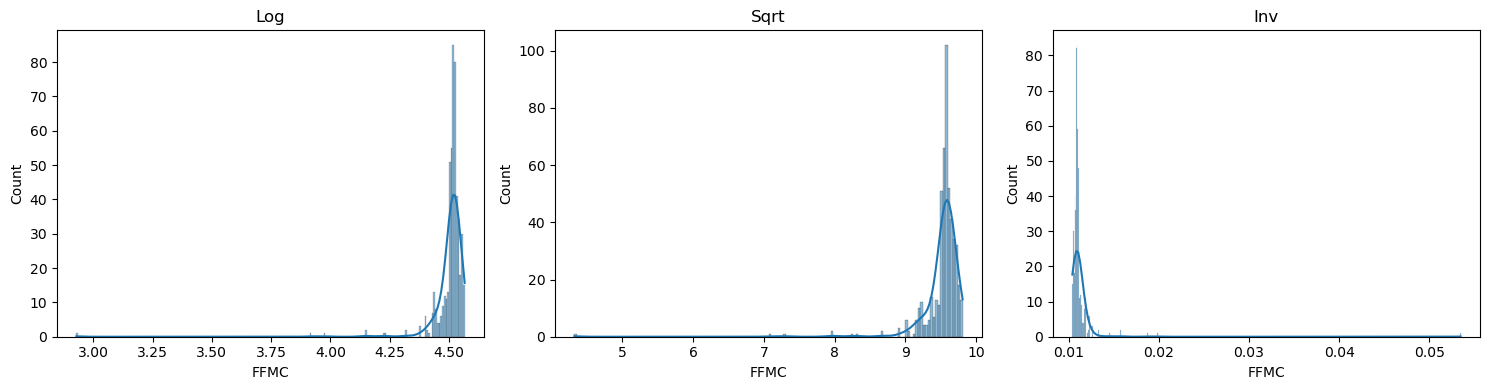

In [42]:
log_FFMC = np.log(X['FFMC'] + 1e-6)
sqrt_FFMC = np.sqrt(X['FFMC'])
inv_FFMC = 1 / (X['FFMC'] + 1e-6)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(log_FFMC, kde=True, ax=axs[0])
axs[0].set_title("Log")

sns.histplot(sqrt_FFMC, kde=True, ax=axs[1])
axs[1].set_title("Sqrt")

sns.histplot(inv_FFMC, kde=True, ax=axs[2])
axs[2].set_title("Inv")

plt.tight_layout()
plt.show()

In [43]:
X['log_FFMC'] = log_FFMC 
X['sqrt_FFMC'] = sqrt_FFMC
X['inv_FFMC'] = inv_FFMC

In [44]:
X.head()

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_sin,month_cos,logRH,log_FFMC,sqrt_FFMC,inv_FFMC
0,7,5,mar,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1.000000,6.123234e-17,3.931826,4.456670,9.284396,0.011601
1,7,4,oct,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,-0.866025,5.000000e-01,3.496508,4.506454,9.518403,0.011038
2,7,4,oct,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,-0.866025,5.000000e-01,3.496508,4.506454,9.518403,0.011038
3,8,6,mar,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1.000000,6.123234e-17,4.574711,4.518522,9.576012,0.010905
4,8,6,mar,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,1.000000,6.123234e-17,4.595120,4.492001,9.449868,0.011198


In [45]:
features_1 = ['temp', 'DMC', 'X', 'DC', 'Y', 'logRH', 'month_cos', 'log_FFMC']
features_2 = ['temp', 'DMC', 'X', 'DC', 'Y', 'logRH', 'month_cos', 'sqrt_FFMC']
features_3 = ['temp', 'DMC', 'X', 'DC', 'Y', 'logRH', 'month_cos', 'inv_FFMC']

In [46]:
X_model1 = X[features_1]
y_model1 = np.log1p(y)
X_model1 = sm.add_constant(X_model1)

model4 = sm.OLS(y_model1, X_model1).fit()

print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.749
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0848
Time:                        21:02:31   Log-Likelihood:                -899.45
No. Observations:                 517   AIC:                             1817.
Df Residuals:                     508   BIC:                             1855.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8868      3.705     -0.509      0.6

In [47]:
X_model2 = X[features_2]
y_model2 = np.log1p(y)
X_model2 = sm.add_constant(X_model2)

model5 = sm.OLS(y_model2, X_model2).fit()

print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.731
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0888
Time:                        21:02:31   Log-Likelihood:                -899.52
No. Observations:                 517   AIC:                             1817.
Df Residuals:                     508   BIC:                             1855.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6282      2.352     -0.267      0.7

In [48]:
X_model3 = X[features_3]
y_model3 = np.log1p(y)
X_model3 = sm.add_constant(X_model3)

model6 = sm.OLS(y_model3, X_model3).fit()

print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.775
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0796
Time:                        21:02:31   Log-Likelihood:                -899.34
No. Observations:                 517   AIC:                             1817.
Df Residuals:                     508   BIC:                             1855.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7997      1.100      0.727      0.4

All three models have weak predictive power, but model 2 has lowest condition number

               temp       DMC         X        DC         Y     logRH  \
temp       1.000000  0.469594 -0.051258  0.496208 -0.024103 -0.501790   
DMC        0.469594  1.000000 -0.048384  0.682192  0.007782  0.084086   
X         -0.051258 -0.048384  1.000000 -0.085916  0.539548  0.080302   
DC         0.496208  0.682192 -0.085916  1.000000 -0.101178 -0.014305   
Y         -0.024103  0.007782  0.539548 -0.101178  1.000000  0.055065   
logRH     -0.501790  0.084086  0.080302 -0.014305  0.055065  1.000000   
month_cos -0.487953 -0.418676 -0.041758 -0.104640 -0.030249 -0.055391   
sqrt_FFMC  0.392111  0.346691 -0.014116  0.297996 -0.045377 -0.247596   

           month_cos  sqrt_FFMC  
temp       -0.487953   0.392111  
DMC        -0.418676   0.346691  
X          -0.041758  -0.014116  
DC         -0.104640   0.297996  
Y          -0.030249  -0.045377  
logRH      -0.055391  -0.247596  
month_cos   1.000000  -0.268293  
sqrt_FFMC  -0.268293   1.000000  


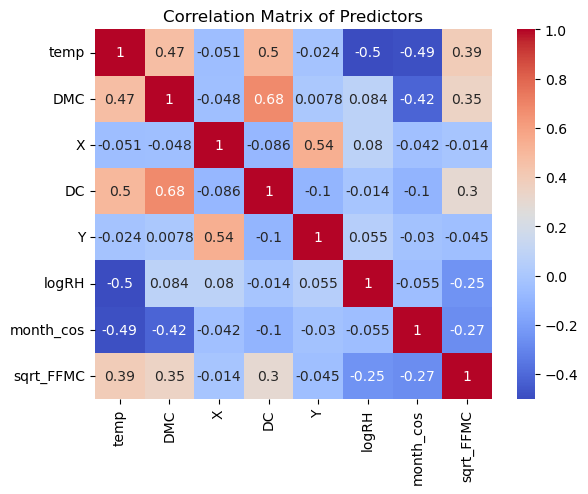

In [49]:
correlation_matrix = X[features_2].corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Predictors')
plt.show()

In [50]:
X_3 = X[features_2]
X_3 = sm.add_constant(X_3)

vif_data = pd.DataFrame()
vif_data['Variable'] = X_3.columns
vif_data['VIF'] = [variance_inflation_factor(X_3.values, i) for i in range(X_3.shape[1])]

print(vif_data)

    Variable          VIF
0      const  1479.436361
1       temp     3.465196
2        DMC     2.551953
3          X     1.432625
4         DC     2.715346
5          Y     1.447701
6      logRH     2.072187
7  month_cos     2.083688
8  sqrt_FFMC     1.297968


Assessing the p-values of our predictors, we will try fitting a new model without these variables : X, Y, DC, logRH

In [51]:
features = ['temp', 'DMC', 'month_cos', 'sqrt_FFMC']

In [52]:
X_model = X[features]
y_model = np.log1p(y)
X_model = sm.add_constant(X_model)

new_model = sm.OLS(y_model, X_model).fit()

print(new_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.597
Date:                Sat, 24 May 2025   Prob (F-statistic):             0.0356
Time:                        21:02:32   Log-Likelihood:                -901.28
No. Observations:                 517   AIC:                             1813.
Df Residuals:                     512   BIC:                             1834.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4835      1.825     -0.265      0.7

               temp       DMC  month_cos  sqrt_FFMC
temp       1.000000  0.469594  -0.487953   0.392111
DMC        0.469594  1.000000  -0.418676   0.346691
month_cos -0.487953 -0.418676   1.000000  -0.268293
sqrt_FFMC  0.392111  0.346691  -0.268293   1.000000


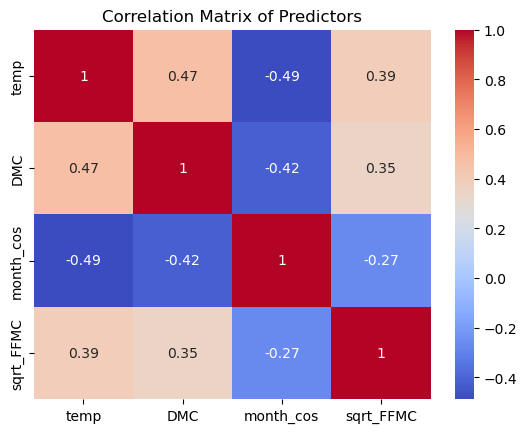

In [53]:
correlation_matrix = X[features].corr()
print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Predictors')
plt.show()

In [54]:
vif_data = pd.DataFrame()
vif_data['Variable'] = X_model.columns
vif_data['VIF'] = [variance_inflation_factor(X_model.values, i) for i in range(X_model.shape[1])]

print(vif_data)

    Variable         VIF
0      const  891.099624
1       temp    1.571140
2        DMC    1.412825
3  month_cos    1.400385
4  sqrt_FFMC    1.233973


In [55]:
X_inter_model = X[['temp', 'DMC', 'month_cos', 'sqrt_FFMC']].copy()

X_inter_model['temp_DMC'] = X_inter_model['temp'] * X_inter_model['DMC']
X_inter_model['temp_month_cos'] = X_inter_model['temp'] * X_inter_model['month_cos']
X_inter_model['temp_sqrt_FFMC'] = X_inter_model['temp'] * X_inter_model['sqrt_FFMC']
X_inter_model['DMC_month_cos'] = X_inter_model['DMC'] * X_inter_model['month_cos']
X_inter_model['DMC_sqrt_FFMC'] = X_inter_model['DMC'] * X_inter_model['sqrt_FFMC']
X_inter_model['month_cos_sqrt_FFMC'] = X_inter_model['month_cos'] * X_inter_model['sqrt_FFMC']

X_inter_model = sm.add_constant(X_inter_model)

y_model = np.log1p(y)

interaction_model = sm.OLS(y_model, X_inter_model).fit()

print(interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.490
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00638
Time:                        21:02:32   Log-Likelihood:                -894.05
No. Observations:                 517   AIC:                             1810.
Df Residuals:                     506   BIC:                             1857.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.6774    

We have good reasoning to look at temp_month and DMC_month further

In [56]:
data['targ_log'] = np.log1p(data['target'])

new_interaction_model = smf.ols(formula='targ_log ~ temp * month_cos + DMC * month_cos', data=data).fit()

# Print the summary
print(new_interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:               targ_log   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     4.074
Date:                Sat, 24 May 2025   Prob (F-statistic):            0.00123
Time:                        21:02:32   Log-Likelihood:                -896.37
No. Observations:                 517   AIC:                             1805.
Df Residuals:                     511   BIC:                             1830.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.7422      0.224      3.

This model does seem to be our cleanest but still lacks significant predictable power. Maybe it is time to explore logistic regression soon.

In [57]:
models = {
    'model': model,
    'model2': model2,
    'model3': model3,
    'model4': model4,
    'model5': model5,
    'model6': model6,
    'new_model': new_model,
    'interaction_model': interaction_model,
    'new_interaction_model': new_interaction_model
}

comparison_df = pd.DataFrame({
    'R-squared': [m.rsquared for m in models.values()],
    'Adj. R-squared': [m.rsquared_adj for m in models.values()],
    'AIC': [m.aic for m in models.values()],
    'BIC': [m.bic for m in models.values()]
}, index=models.keys())

print(comparison_df)

                       R-squared  Adj. R-squared          AIC          BIC
model                   0.030653        0.013446  1816.842436  1859.322865
model2                  0.026379        0.011046  1817.116927  1855.349312
model3                 -0.062973       -0.062973  1846.510850  1850.758893
model4                  0.026805        0.011479  1816.890849  1855.123235
model5                  0.026530        0.011200  1817.036543  1855.268929
model6                  0.027189        0.011870  1816.686380  1854.918766
new_model               0.019886        0.012229  1812.553209  1833.793423
interaction_model       0.046905        0.028069  1810.100795  1856.829266
new_interaction_model   0.038332        0.028922  1804.730696  1830.218953


new_interaction_model is best by both adjusted r^2 and AIC

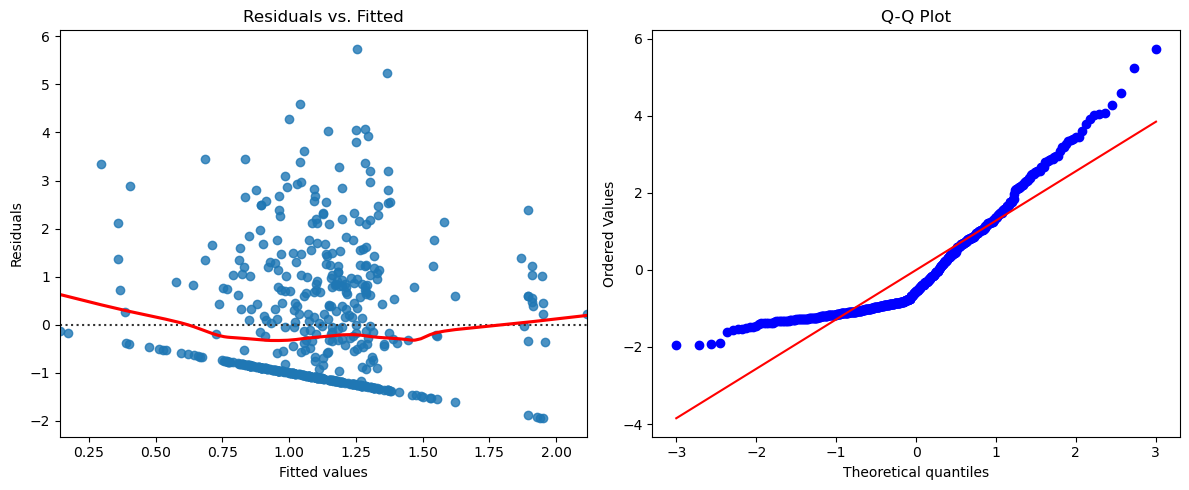

In [58]:
residuals = new_interaction_model.resid
fitted = new_interaction_model.fittedvalues

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.residplot(x=fitted, y=residuals, lowess=True, ax=axs[0], line_kws={'color': 'red'})
axs[0].set_title('Residuals vs. Fitted')
axs[0].set_xlabel('Fitted values')
axs[0].set_ylabel('Residuals')

stats.probplot(residuals, dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

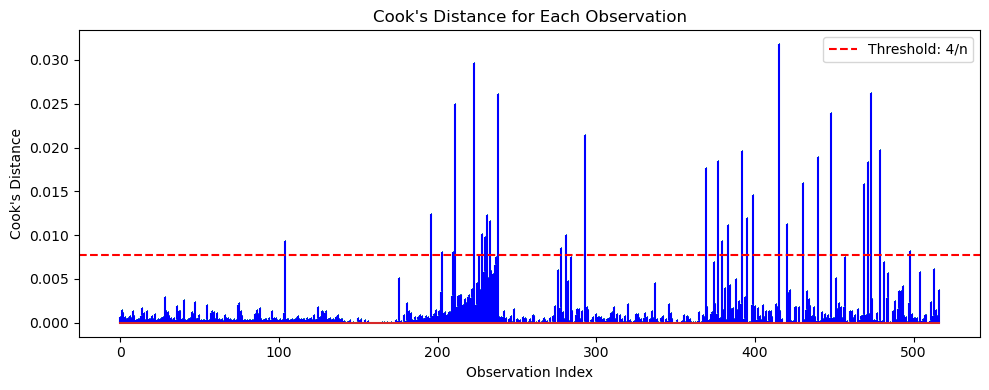

Number of influential points (Cook's D > 4/n): 31
Indices of influential observations: [104 196 203 210 211 223 228 230 231 233 238 278 281 293 369 377 379 383
 392 395 399 415 420 430 440 448 469 471 473 479 498]


In [59]:
influence = new_interaction_model.get_influence()
cooks_d, _ = influence.cooks_distance

plt.figure(figsize=(10, 4))
markerline, stemlines, baseline = plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.setp(stemlines, 'color', 'blue')
plt.axhline(4 / len(cooks_d), color='red', linestyle='--', label='Threshold: 4/n')
plt.title("Cook's Distance for Each Observation")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.legend()
plt.tight_layout()
plt.show()

threshold = 4 / len(cooks_d)
influential_points = np.where(cooks_d > threshold)[0]
print(f"Number of influential points (Cook's D > 4/n): {len(influential_points)}")
print("Indices of influential observations:", influential_points)

Significant number of influential observations using Cook's distance, which makes sense as R^2 is very low

In [60]:
train_data_x = data.drop(columns = ['target', 'targ_log'])
train_data_y =data['target']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(train_data_x, train_data_y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)

print("Ridge R²:", r2_score(y_test, y_pred_ridge))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

Ridge R²: 0.010229910903708395
Ridge RMSE: 108.01469513201008


In [63]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

lasso_pred = lasso.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print("Lasso Test MSE:", lasso_mse)
print("Lasso Coefficients:", lasso.coef_)

Lasso Test MSE: 11685.900666792055
Lasso Coefficients: [  4.97476459   0.          -0.120552     9.15440221 -11.94294459
  -1.12215061   2.90445279  -2.74203964   1.29154287  -0.74359254
  -8.42409692   3.08527559]


try ridge and lasso with our interaction/transformations

In [64]:
data.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_sin,month_cos,target,targ_log
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1.000000,6.123234e-17,0.0,0.0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,-0.866025,5.000000e-01,0.0,0.0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,-0.866025,5.000000e-01,0.0,0.0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1.000000,6.123234e-17,0.0,0.0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,1.000000,6.123234e-17,0.0,0.0


In [65]:
train_model_x = pd.DataFrame()
train_model_x['temp_month'] = data['month_cos'] * data['temp']
train_model_x['DMC_month'] = data['month_cos'] * data['DMC']
train_model_y =data['targ_log']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(train_model_x, train_model_y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)

print("Ridge R²:", r2_score(y_test, y_pred_ridge))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

Ridge R²: -0.00025809202383864083
Ridge RMSE: 1.4827099591473476


In [68]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

lasso_pred = lasso.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print("Lasso Test MSE:", lasso_mse)
print("Lasso Coefficients:", lasso.coef_)

Lasso Test MSE: 2.1992238175877623
Lasso Coefficients: [0. 0.]


Neither model either with the data or interactions performs well. Moving onto logistic

In [69]:
percentiles = [10, 15, 25, 35, 50, 75]

for perc in percentiles:
    threshold = np.percentile(data['target'], perc)
    print(f"{perc}th percentile ({threshold:.2f})")

10th percentile (0.00)
15th percentile (0.00)
25th percentile (0.00)
35th percentile (0.00)
50th percentile (0.52)
75th percentile (6.57)


In [70]:
data['target'].describe()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: target, dtype: float64

We'll go with 75%. Forest fires can be such devistating events that we want to be sensitive to most events, but so many zero values really skews the median

In [71]:
threshold = np.percentile(data['target'], 75)

In [72]:
data['target_bi'] = (data['target'] > threshold).astype(int)

In [73]:
data.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_sin,month_cos,target,targ_log,target_bi
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,1.000000,6.123234e-17,0.0,0.0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,-0.866025,5.000000e-01,0.0,0.0,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,-0.866025,5.000000e-01,0.0,0.0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,1.000000,6.123234e-17,0.0,0.0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,1.000000,6.123234e-17,0.0,0.0,0


In [74]:
data['target_bi'].value_counts()

target_bi
0    388
1    129
Name: count, dtype: int64

In [75]:
X_train, X_test, y_train, y_test = train_test_split(train_data_x, data['target_bi'], test_size=0.2, random_state=42)

In [76]:
print("X_train dimensions:", X_train.shape)
print("X_test dimensions:", X_test.shape)
print("y_train dimensions:", y_train.shape)
print("y_test dimensions:", y_test.shape)

X_train dimensions: (413, 12)
X_test dimensions: (104, 12)
y_train dimensions: (413,)
y_test dimensions: (104,)


In [77]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Get dimensions
print("Dimensions of X_train_scaled:", X_train_scaled.shape)
print("Dimensions of X_test_scaled:", X_test_scaled.shape)

Dimensions of X_train_scaled: (413, 12)
Dimensions of X_test_scaled: (104, 12)


In [78]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Output coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: [-1.15478944]
Coefficients: [[ 0.16330198 -0.00794471  0.13437398  0.43787705 -0.50164576 -0.00160432
  -0.07830677 -0.1717624   0.02316899  0.15465246 -0.3347353   0.4908768 ]]


In [79]:
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred_class = model.predict(X_test_scaled)

# Display predictions
print("Predicted Probabilities:", y_pred_prob[:5])
print("Predicted Classes:", y_pred_class[:5])

Predicted Probabilities: [0.07185064 0.33040593 0.33965685 0.25428186 0.17746986]
Predicted Classes: [0 0 0 0 0]


In [80]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("Accuracy Score:", accuracy_score(y_test, y_pred_class))
print("Classification Report:\n", classification_report(y_test, y_pred_class))

Confusion Matrix:
 [[78  0]
 [24  2]]
Accuracy Score: 0.7692307692307693
Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.87        78
           1       1.00      0.08      0.14        26

    accuracy                           0.77       104
   macro avg       0.88      0.54      0.50       104
weighted avg       0.82      0.77      0.69       104



In [81]:
vif = pd.DataFrame()
vif["Variable"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]
print(vif)

     Variable        VIF
0           X   1.444192
1           Y   1.435192
2        FFMC   1.806472
3         DMC   3.127192
4          DC  17.866023
5         ISI   1.865887
6        temp   4.051007
7          RH   2.542473
8        wind   1.160571
9        rain   1.055721
10  month_sin  14.596859
11  month_cos   2.313454


very biased towards predicting 0, need to try different threshold

In [82]:
threshold = np.percentile(data['target'], 50)
data['target_bi'] = (data['target'] > threshold).astype(int)

X_train, X_test, y_train, y_test = train_test_split(train_data_x, data['target_bi'], test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred_class = model.predict(X_test_scaled)

# Display predictions
print("Predicted Probabilities:", y_pred_prob[:5])
print("Predicted Classes:", y_pred_class[:5])

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("Accuracy Score:", accuracy_score(y_test, y_pred_class))
print("Classification Report:\n", classification_report(y_test, y_pred_class))

vif = pd.DataFrame()
vif["Variable"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]
print(vif)

Intercept: [-0.00032987]
Coefficients: [[ 0.10033496  0.08037829  0.28419146  0.06809706 -0.04885517 -0.18253507
   0.16225647  0.04065543  0.18985737  0.03131236 -0.10674636  0.17771058]]
Predicted Probabilities: [0.41307388 0.60465017 0.56692356 0.52022072 0.44975564]
Predicted Classes: [0 1 1 1 0]
Confusion Matrix:
 [[27 26]
 [25 26]]
Accuracy Score: 0.5096153846153846
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.51      0.51        53
           1       0.50      0.51      0.50        51

    accuracy                           0.51       104
   macro avg       0.51      0.51      0.51       104
weighted avg       0.51      0.51      0.51       104

     Variable        VIF
0           X   1.444192
1           Y   1.435192
2        FFMC   1.806472
3         DMC   3.127192
4          DC  17.866023
5         ISI   1.865887
6        temp   4.051007
7          RH   2.542473
8        wind   1.160571
9        rain   1.055721

In [83]:
#try without high VIF DC and month_sin

threshold = np.percentile(data['target'], 50)
data['target_bi'] = (data['target'] > threshold).astype(int)

X_train, X_test, y_train, y_test = train_test_split(train_data_x.drop(columns= ['DC', 'month_sin']), data['target_bi'], test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred_class = model.predict(X_test_scaled)

# Display predictions
print("Predicted Probabilities:", y_pred_prob[:5])
print("Predicted Classes:", y_pred_class[:5])

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("Accuracy Score:", accuracy_score(y_test, y_pred_class))
print("Classification Report:\n", classification_report(y_test, y_pred_class))

vif = pd.DataFrame()
vif["Variable"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]
print(vif)

Intercept: [-0.00010807]
Coefficients: [[ 0.09730442  0.07803929  0.28595639  0.08190891 -0.17472142  0.20101544
   0.06251079  0.18576902  0.0272913   0.18932257]]
Predicted Probabilities: [0.42150336 0.61016745 0.56887307 0.51634462 0.46270079]
Predicted Classes: [0 1 1 1 0]
Confusion Matrix:
 [[29 24]
 [24 27]]
Accuracy Score: 0.5384615384615384
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.55      0.55        53
           1       0.53      0.53      0.53        51

    accuracy                           0.54       104
   macro avg       0.54      0.54      0.54       104
weighted avg       0.54      0.54      0.54       104

    Variable       VIF
0          X  1.435011
1          Y  1.411653
2       FFMC  1.790486
3        DMC  1.743700
4        ISI  1.834261
5       temp  3.216355
6         RH  2.284886
7       wind  1.142146
8       rain  1.046965
9  month_cos  1.629943


In [84]:
#try with interaction terms

threshold = np.percentile(data['target'], 50)
data['target_bi'] = (data['target'] > threshold).astype(int)

X_train, X_test, y_train, y_test = train_test_split(train_model_x, data['target_bi'], test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred_class = model.predict(X_test_scaled)

# Display predictions
print("Predicted Probabilities:", y_pred_prob[:5])
print("Predicted Classes:", y_pred_class[:5])

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("Accuracy Score:", accuracy_score(y_test, y_pred_class))
print("Classification Report:\n", classification_report(y_test, y_pred_class))

vif = pd.DataFrame()
vif["Variable"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]
print(vif)

Intercept: [0.00497457]
Coefficients: [[-0.26881707  0.25122937]]
Predicted Probabilities: [0.55524727 0.47482279 0.47422207 0.50353532 0.53573823]
Predicted Classes: [1 0 0 1 1]
Confusion Matrix:
 [[15 38]
 [14 37]]
Accuracy Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.28      0.37        53
           1       0.49      0.73      0.59        51

    accuracy                           0.50       104
   macro avg       0.51      0.50      0.48       104
weighted avg       0.51      0.50      0.47       104

     Variable       VIF
0  temp_month  3.465787
1   DMC_month  3.465787


In [85]:
#try with transformations 

threshold = np.percentile(data['target'], 50)
data['target_bi'] = (data['target'] > threshold).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X[features_2], data['target_bi'], test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
y_pred_class = model.predict(X_test_scaled)

# Display predictions
print("Predicted Probabilities:", y_pred_prob[:5])
print("Predicted Classes:", y_pred_class[:5])

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))
print("Accuracy Score:", accuracy_score(y_test, y_pred_class))
print("Classification Report:\n", classification_report(y_test, y_pred_class))

vif = pd.DataFrame()
vif["Variable"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]
print(vif)

Intercept: [0.00117366]
Coefficients: [[ 0.17208626  0.06606258  0.10367094 -0.01035249  0.06923712  0.10701904
   0.21963378  0.20516297]]
Predicted Probabilities: [0.38666491 0.60605884 0.58059212 0.56593701 0.51479348]
Predicted Classes: [0 1 1 1 1]
Confusion Matrix:
 [[31 22]
 [22 29]]
Accuracy Score: 0.5769230769230769
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.58      0.58        53
           1       0.57      0.57      0.57        51

    accuracy                           0.58       104
   macro avg       0.58      0.58      0.58       104
weighted avg       0.58      0.58      0.58       104

    Variable       VIF
0       temp  3.499507
1        DMC  2.538439
2          X  1.421931
3         DC  2.721240
4          Y  1.422209
5      logRH  2.191872
6  month_cos  2.058856
7  sqrt_FFMC  1.288412


## Final Thoughts:

Multiple continuous regression models were attempted with extremely low R^2 scores. Models were marginally improved with interaction, but were nearly negligible. Transformations were tried via BoxCox etc to find better fits, but model was not able to be improved. 

Instead, a logistic regression model proved more effective. Using the median as a threshold, the model showed 54% accuracy or slightly better than random. A 75% threshold had a high accuracy of 77% but poor recall and F1-score. Using our interaction term model simplified but did not add any meaningful predictive power. The best model used transformations from our previous regression models, specifically sqrt_FFMC and logRH. The model achieved 58% accurate with moderate F1-score, precision and recall. 

Overall, the models produced did not prove meaningful in the context of identifying wildfires for prevention. Deeper learning tools are needed to properly assess the data. Logistical regression appears the most fitting for this study as of now, particularly when proper transformations are applied. 